### Show Net Input (Shuffled)
Our network receives a video of blinking emitters as input. Each video contains a pre-determined number of frames and the number of emitters we observe is bounded by another pre-determined parameter - maxSources.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import h5py
import os

path = os.path.join('..', '..', 'DataSimulation', 'Dataset_im64_f8_s2')
numSamples = 5000
data_file = os.path.join(path, str(np.random.randint(numSamples)) + '.mat')
with h5py.File(data_file, 'r') as f:
    sample_x = np.array(f.get('features'))
    sample_y = np.array(f.get('labels'))
sample_x = np.transpose(sample_x, (1, 2, 0))
sample_y = np.transpose(sample_y, (1, 2, 0))

numFrames = sample_x.shape[2]

fig = plt.figure()
im = plt.imshow(sample_x[:,:,0], animated=True)

def update(i):
    img = sample_x[:,:,i]
    im.set_data(img)
    
ani = animation.FuncAnimation(fig, update, frames=numFrames, repeat=True)  
plt.show()   

<Figure size 640x480 with 1 Axes>

### Validation Results 
After training the model, we first show the estimated (predicted by our model) sources versus the ground truth. The input is the video showed above and it is randomly selected from the validation set.

In [38]:
import tensorflow as tf

def evalPredictions(input_tensor):
    tf.reset_default_graph()  
    imported_graph = tf.train.import_meta_graph(os.path.join('..', 'checkpoints', 'ckpt_im64_f8_s2',
                                                             'im64_f8_s2_2018-05-11_1356.meta'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name('x:0')
    keep_prob = graph.get_tensor_by_name('dropout/Placeholder:0')
    y_conv = graph.get_tensor_by_name('reshape_y/Reshape:0')
    with tf.Session() as sess:
        imported_graph.restore(sess, tf.train.latest_checkpoint(os.path.join('..', 'checkpoints', 'ckpt_im64_f8_s2')))
        feed_dict = {x: input_tensor, keep_prob: 0}
        y_pred = sess.run(y_conv, feed_dict = feed_dict)
    return y_pred

def removeNons(y_pred, y_labels):
    maxSources = y_labels.shape[-1]
    idxs = []
    for i in range(maxSources):
        if (y_labels == np.zeros(y_labels.shape)).all():
            continue
        idxs = np.append(idxs, i).astype(int)
    y_tot = np.append(y_labels[:,:,idxs], y_pred[:,:,idxs], axis=2)
    return y_tot
    
def showPredictions(y_pred, y_labels):
        y_preds = y_pred[0,:,:,:]
        y_tot = removeNons(y_preds, y_labels)
        numSources = y_labels.shape[-1]
        fig, axes = plt.subplots(2, numSources)
        for i, ax in enumerate(axes.flat):
            ax.imshow(y_tot[:,:,i], aspect='auto')
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()

INFO:tensorflow:Restoring parameters from C:\Users\orrav\Documents\Technion\Alex_Orr_Project\NNflow\checkpoints\ckpt_im64_f8_s2\im64_f8_s2_2018-05-11_1356


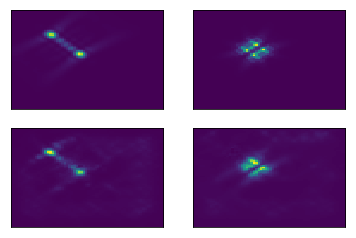

In [39]:
input_tensor = np.expand_dims(sample_x, axis=0)
y_pred = evalPredictions(input_tensor)
showPredictions(y_pred, sample_y)